In [1]:
# 0. 라이브러리 설치 및 로드
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.font_manager as fm
import matplotlib.gridspec as gridspec
import math
from influxdb_client import InfluxDBClient
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.ensemble import StackingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler, PolynomialFeatures
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.isotonic import IsotonicRegression
import shap
import joblib

/opt/homebrew/anaconda3/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# 1. 폰트 설정
font_path = "/System/Library/Fonts/Supplemental/AppleGothic.ttf"
fontprop = fm.FontProperties(fname=font_path)
font_name = fontprop.get_name()
mpl.rcParams['font.family'] = font_name
mpl.rcParams['axes.unicode_minus'] = False
sns.set_style("whitegrid")
plt.rcParams['font.family'] = font_name

In [3]:
# 2. InfluxDB 연결 함수
def get_influx_client():
    INFLUX_URL   = "https://influx.aiot2.live"
    INFLUX_TOKEN = "RmaabELI9VpYPRu4nt_xBZX5l3Gv5lx8XnR4mVZnqep4Ya3eYrfpLUk4Y4dYE4J0mlcFHFPLUCKh8a4jq_lMNw=="
    INFLUX_ORG   = "aiot2-team2-coffee"
    INFLUX_BUCKET= "coffee-mqtt"
    client = InfluxDBClient(url=INFLUX_URL, token=INFLUX_TOKEN, org=INFLUX_ORG)
    return client, INFLUX_BUCKET

sensor_types = ["temperature", "humidity", "co2"]
target_locations = ["8인 책상", "왼쪽 뒤", "안쪽벽 중앙", "보드"]

client, INFLUX_BUCKET = get_influx_client()
read_api = client.query_api()

sensor_filter = ' or '.join([f'r["type"] == "{t}"' for t in sensor_types])
location_filter = ' or '.join([f'r["location"] == "{loc}"' for loc in target_locations])

flux = f'''
from(bucket: "{INFLUX_BUCKET}")
  |> range(start: -7d)
  |> filter(fn: (r) => r["_measurement"] == "sensor")
  |> filter(fn: (r) => r["_field"] == "value")
  |> filter(fn: (r) => {sensor_filter})
  |> filter(fn: (r) => {location_filter})
  |> aggregateWindow(every: 5m, fn: mean, createEmpty: false)
  |> yield(name: "mean")
'''


In [4]:
# 데이터 쿼리 및 전처리
df = read_api.query_data_frame(flux)
if isinstance(df, list):
    df = pd.concat(df)

df = df.reset_index().rename(columns={"_time": "time"}).set_index("time")

pivot_df = df.pivot_table(index=['time', 'location'], columns='type', values='_value', aggfunc='first').reset_index()
pivot_df = pivot_df.sort_values(by='time')

# 면적 매핑
location_area_map = {"8인 책상": 64.65, "왼쪽 뒤": 109.21, "안쪽벽 중앙": 25.13, "보드": 31.59}
pivot_df['area'] = pivot_df['location'].map(location_area_map)
pivot_df['co2_per_area'] = pivot_df['co2'] / pivot_df['area']

# 결측치 보정 (IterativeImputer)
imputer = IterativeImputer(random_state=42)
imputed = imputer.fit_transform(pivot_df[['co2', 'humidity', 'temperature']])
pivot_df[['co2', 'humidity', 'temperature']] = imputed


/opt/homebrew/anaconda3/lib/python3.12/site-packages/influxdb_client/client/warnings.py:31: MissingPivotFunction: The query doesn't contains the pivot() function.

The result will not be shaped to optimal processing by pandas.DataFrame. Use the pivot() function by:

    
from(bucket: "coffee-mqtt")
  |> range(start: -7d)
  |> filter(fn: (r) => r["_measurement"] == "sensor")
  |> filter(fn: (r) => r["_field"] == "value")
  |> filter(fn: (r) => r["type"] == "temperature" or r["type"] == "humidity" or r["type"] == "co2")
  |> filter(fn: (r) => r["location"] == "8인 책상" or r["location"] == "왼쪽 뒤" or r["location"] == "안쪽벽 중앙" or r["location"] == "보드")
  |> aggregateWindow(every: 5m, fn: mean, createEmpty: false)
  |> yield(name: "mean")
 |> pivot(rowKey:["_time"], columnKey: ["_field"], valueColumn: "_value")

You can disable this warning by:
    import warnings
    from influxdb_client.client.warnings import MissingPivotFunction

    warnings.simplefilter("ignore", MissingPivotFunction)

Fo

In [5]:
def compute_discomfort_index(t, rh):
    return 0.81 * t + 0.01 * rh * (0.99 * t - 14.3) + 46.3

augmented_samples = []
temps = np.arange(15, 31, 1)
humis = np.arange(15, 95, 5)
co2s = np.arange(400, 1600, 100)
for t in temps:
    for h in humis:
        for c in co2s:
            di = compute_discomfort_index(t, h)
            if di < 65 or di > 85:
                augmented_samples.append({"temperature": t, "humidity": h, "co2": c, "DI": di})

aug_df = pd.DataFrame(augmented_samples)
aug_df = aug_df[
    ~((aug_df['temperature'] < 15) & (aug_df['humidity'] > 80)) & 
    ~((aug_df['temperature'] > 32) & (aug_df['humidity'] < 40))
]
aug_df = aug_df.sample(frac=0.1, random_state=42) 

In [6]:
# 원본 데이터 + 타겟 생성
pivot_df['DI'] = compute_discomfort_index(pivot_df['temperature'], pivot_df['humidity'])
temp_df = pivot_df[['temperature', 'humidity', 'co2', 'DI']].copy()
X_all_df = pd.concat([
    temp_df[['temperature', 'humidity', 'co2']],
    aug_df[['temperature', 'humidity', 'co2']]
], ignore_index=True)

y_all = pd.concat([
    temp_df['DI'],
    aug_df['DI']
], ignore_index=True)

scaler = RobustScaler()
X_all = scaler.fit_transform(X_all_df)
X_scaled = X_all[:len(temp_df)]
X_aug = X_all[len(temp_df):]

y_aug = aug_df['DI'].reset_index(drop=True)


In [7]:
model = XGBRegressor(
    objective='reg:squarederror',
    learning_rate=0.1,
    max_depth=5,
    n_estimators=200,
    subsample=1.0,
    early_stopping_rounds=20,
    verbosity=0,
    eval_metric='rmse'
)

tscv = TimeSeriesSplit(n_splits=3, test_size=24 * 3)
results = []

/opt/homebrew/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) AppleGothic.
  fig.canvas.print_figure(bytes_io, **kw)


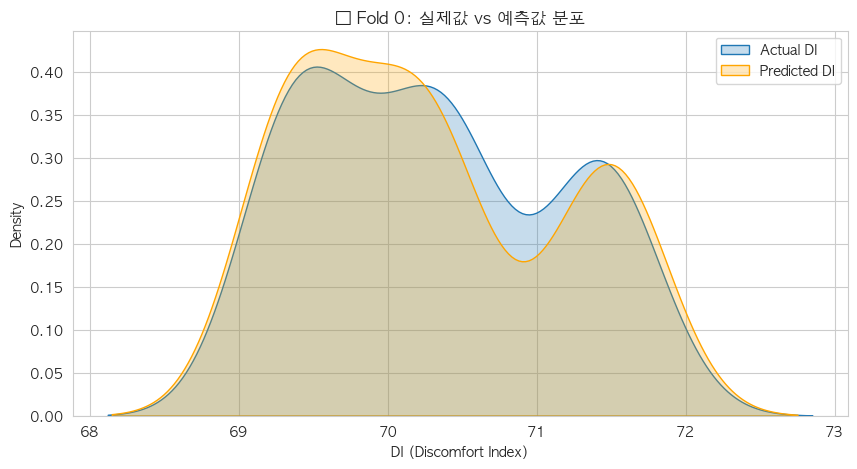

/opt/homebrew/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) AppleGothic.
  fig.canvas.print_figure(bytes_io, **kw)


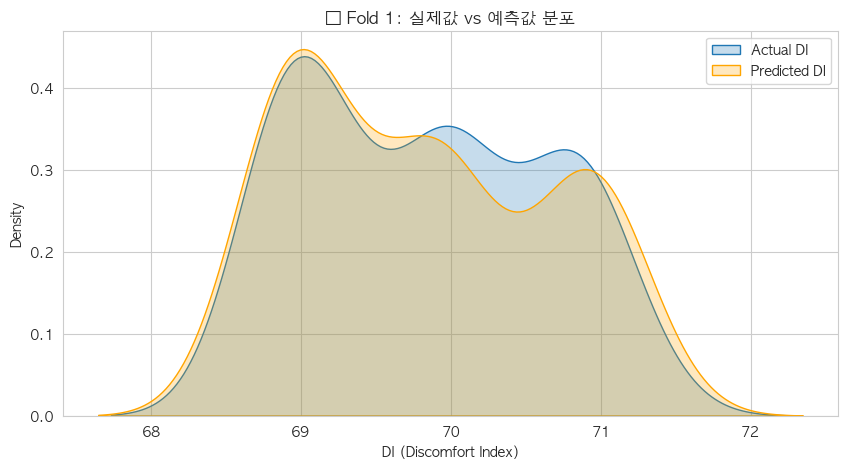

/opt/homebrew/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) AppleGothic.
  fig.canvas.print_figure(bytes_io, **kw)


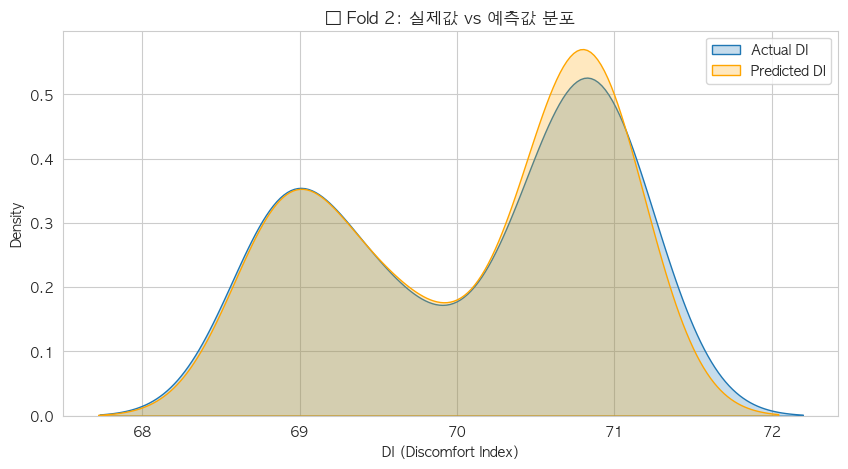

   Fold      RMSE       MAE        R2
0     0  0.119796  0.095386  0.978826
1     1  0.081933  0.068485  0.989287
2     2  0.076397  0.060450  0.992257

✨ 평균 성능:
RMSE    0.092709
MAE     0.074774
R2      0.986790
dtype: float64


In [8]:
for fold, (train_idx, val_idx) in enumerate(tscv.split(X_scaled)):
    X_train = np.concatenate([X_scaled[train_idx], X_aug])
    y_train = pd.concat([y_all.iloc[train_idx], y_aug], ignore_index=True)
    X_val = X_scaled[val_idx]
    y_val = y_all.iloc[val_idx]

    
    model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False)
    preds = model.predict(X_val)

    plt.figure(figsize=(10, 5))
    sns.kdeplot(y_val, label='Actual DI', fill=True)
    sns.kdeplot(preds, label='Predicted DI', fill=True, color='orange')
    plt.title(f"\U0001F4CA Fold {fold}: 실제값 vs 예측값 분포")
    plt.xlabel("DI (Discomfort Index)")
    plt.legend()
    plt.grid(True)
    plt.show()

    rmse = np.sqrt(mean_squared_error(y_val, preds))
    mae = mean_absolute_error(y_val, preds)
    r2 = r2_score(y_val, preds)
    results.append((fold, rmse, mae, r2))


results_df = pd.DataFrame(results, columns=['Fold', 'RMSE', 'MAE', 'R2'])
print(results_df)
print("\n\u2728 평균 성능:")
print(results_df[['RMSE', 'MAE', 'R2']].mean())


 95%|=================== | 5934/6263 [00:16<00:00]       

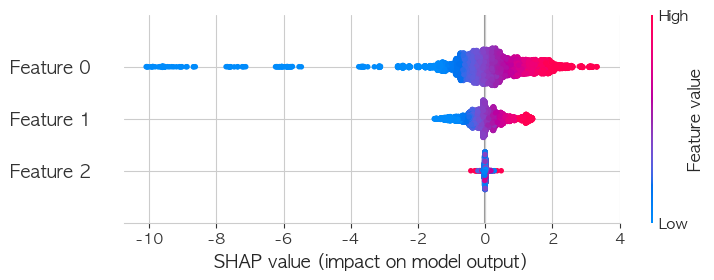

In [9]:
# 8. SHAP 해석
X_all = np.concatenate([X_scaled, X_aug])
explainer = shap.Explainer(model, X_all)
shap_values = explainer(X_all)
shap.plots.beeswarm(shap_values)



# 민감도 분석 
### 특정 feature를 ±10%, ±20%, ±30% 변동시켰을 때 comfort_index 예측값이 얼마나 변하는지 수치화.

In [10]:
def sensitivity_analysis(model, X, feature_list, percentage_changes=[-0.3, -0.2, -0.1, 0.1, 0.2, 0.3]):
    base_pred = model.predict(X)
    sensitivity_result = {}
    for feature in feature_list:
        changes = []
        for pct in percentage_changes:
            X_modified = X.copy()
            X_modified[feature] *= (1 + pct)
            pred_modified = model.predict(X_modified)
            diff = np.mean(np.abs(pred_modified - base_pred))
            changes.append(diff)
        sensitivity_result[feature] = changes
    result_df = pd.DataFrame(sensitivity_result, index=[f"{int(pct*100)}%" for pct in percentage_changes])
    return result_df


      temperature  humidity       co2
-30%     0.242015  0.123455  0.012699
-20%     0.151028  0.081611  0.009695
-10%     0.070537  0.040620  0.005537
10%      0.084315  0.036215  0.005729
20%      0.153643  0.067172  0.007966
30%      0.217597  0.096573  0.010640


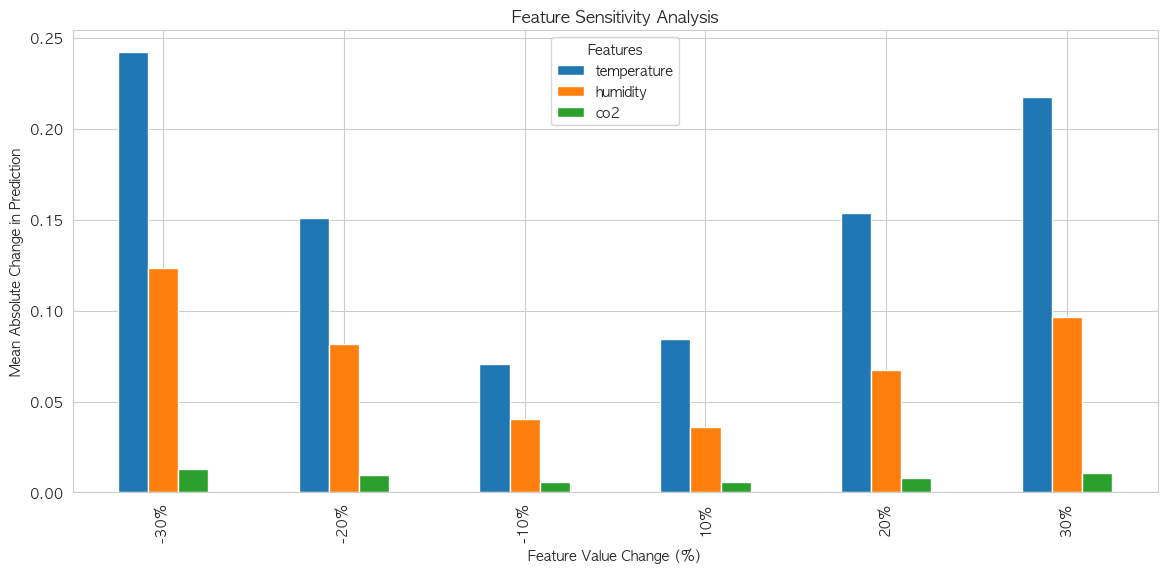

In [11]:

important_features = ['temperature', 'humidity', 'co2']
X_df = pd.DataFrame(X_all, columns=important_features)
sensitivity_df = sensitivity_analysis(model, X_df, important_features)
print(sensitivity_df)

sensitivity_df.plot(kind='bar', figsize=(14, 6))
plt.title("Feature Sensitivity Analysis")
plt.ylabel("Mean Absolute Change in Prediction")
plt.xlabel("Feature Value Change (%)")
plt.legend(title="Features")
plt.grid(True)
plt.show()

# 하이퍼 파라미터 튜닝

In [12]:
tscv = TimeSeriesSplit(n_splits=5, test_size=24*3)
xgb = XGBRegressor(objective='reg:squarederror')

param_grid = {
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 4, 5],
    'n_estimators': [100, 200],
    'subsample': [0.8, 1.0]
}

grid_search = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    scoring='neg_root_mean_squared_error',
    cv=tscv,
    verbose=2,
    n_jobs=-1
)

grid_search.fit(X_all, y_all)

print("Best Parameters:", grid_search.best_params_)
print("Best RMSE Score:", -grid_search.best_score_)


Fitting 5 folds for each of 36 candidates, totalling 180 fits
[CV] END learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.8; total time=   0.0s
[CV] END learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.8; total time=   0.0s
[CV] END learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.8; total time=   0.0s
[CV] END learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.8; total time=   0.0s
[CV] END learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.8; total time=   0.0s
[CV] END learning_rate=0.01, max_depth=3, n_estimators=200, subsample=0.8; total time=   0.0s
[CV] END learning_rate=0.01, max_depth=3, n_estimators=200, subsample=0.8; total time=   0.0s
[CV] END learning_rate=0.01, max_depth=3, n_estimators=100, subsample=1.0; total time=   0.0s
[CV] END learning_rate=0.01, max_depth=3, n_estimators=200, subsample=1.0; total time=   0.0s
[CV] END learning_rate=0.01, max_depth=3, n_estimators=100, subsample=1.0; total time=   0.0

In [13]:
y_pred_full = model.predict(X_all)
iso_model = IsotonicRegression(out_of_bounds='clip')
iso_model.fit(y_pred_full, y_all)


IsotonicRegression(out_of_bounds='clip')

In [14]:
# 저장
joblib.dump(model, 'model.pkl')
joblib.dump(scaler, 'scaler.pkl')
joblib.dump(iso_model, 'iso_model.pkl')


['iso_model.pkl']